In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! kaggle datasets list

In [ ]:
!unzip aptos2019-blindness-detection.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_i

In [ ]:
import pandas as pd #For reading csv files.
import numpy as np
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.

In [ ]:
device = torch.device('cuda')


In [ ]:
path = "/content/aptos2019-blindness-detection/"
train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


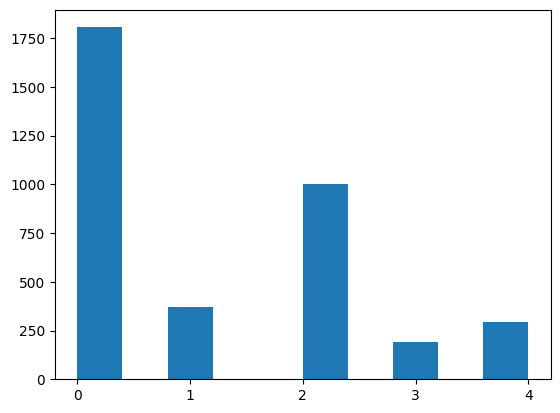

In [ ]:
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

In [ ]:
from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights)

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


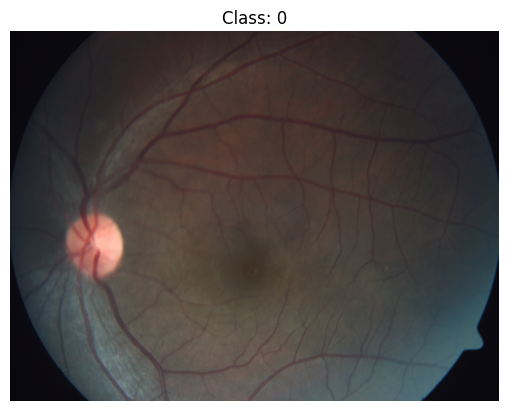

In [ ]:
#For getting a random image from our training set.
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')#Image file.
sample_image = Image.open(sample_image)
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}') #Class of the random image.
plt.show()

In [ ]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class.

    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''

    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.

    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.

        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.

        else:
            return image #If train != True, return image.


In [ ]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set.
train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360])

In [ ]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False) #DataLoader for validation_set.

In [ ]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(pretrained=True)


model.fc = nn.Sequential(nn.Linear(512,256),
                         nn.ReLU(inplace=True),
                         nn.Linear(256,128),
                         nn.ReLU(inplace=True),
                         nn.Linear(128,64),
                         nn.ReLU(inplace=True),
                         nn.Linear(64,5),
                    )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 99.5MB/s]


In [ ]:
model = model.to(device) #Moves the model to the device.

In [ ]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.

        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss

In [ ]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad():

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss

In [ ]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-----jk=-[]'in_loss = train(train_dataloader,model,loss_fn,optimizer)
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn)
        valid_losses.append(valid_loss)

    print('\nTraining has completed!')

    return train_losses,valid_losses

In [20]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
nb_epochs = 60
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/60
-------------------------------

Training Loss = 1.609049	Accuracy on Training set = 8.267717% [273/3302]

Validation Loss = 1.609320	Accuracy on Validation set = 8.333333% [30/360]

Epoch 2/60
-------------------------------

Training Loss = 1.606304	Accuracy on Training set = 9.206541% [304/3302]

Validation Loss = 1.606516	Accuracy on Validation set = 10.000000% [36/360]

Epoch 3/60
-------------------------------

Training Loss = 1.604074	Accuracy on Training set = 13.870382% [458/3302]

Validation Loss = 1.604211	Accuracy on Validation set = 19.722222% [71/360]

Epoch 4/60
-------------------------------

Training Loss = 1.601828	Accuracy on Training set = 20.805572% [687/3302]

Validation Loss = 1.601456	Accuracy on Validation set = 28.333333% [102/360]

Epoch 5/60
-------------------------------

Training Loss = 1.598557	Accuracy on Training set = 33.010297% [1090/3302]

Validation Loss = 1.599217	Accuracy on Validation set = 36.944444% [133/360]

Epoch 6/60
--------

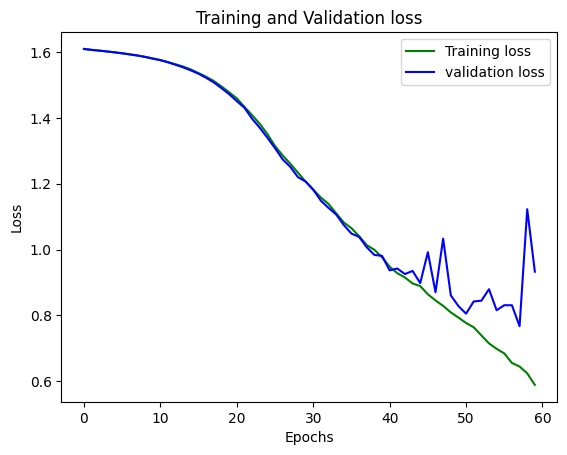

In [21]:
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
torch.save(model,'CNN_for_DR.pth')

In [23]:
test_set = dataset(test_df,f'{path}test_images',image_transform = image_transform,train = False )

test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False)

In [24]:
def test(dataloader,model):
    '''
    test function predicts the labels given an image batches.

    Args :
         dataloader: DataLoader for the test_set.
         model: Given an input produces an output by multiplying the input with the model weights.

    Returns :
         List of predicted labels.
    '''

    model.eval() #Sets the model for evaluation.

    labels = [] #List to store the predicted labels.

    with torch.no_grad():

        for batch,x in enumerate(dataloader):

            output = model(x.to(device))

            predictions = output.argmax(dim=1).cpu().detach().tolist() #Predicted labels for an image batch.
            labels.extend(predictions)

    print('Testing has completed')

    return labels

In [25]:
labels = test(test_dataloader,model)

Testing has completed
